# Pairs Trading Using Sentiment
## Author: Gerardo Salazar
#### Date: 2018-01-25
Construct the pairs trading spread by using sentiment data imported from _Quantopian's_ **StockTwits** data.

EDIT **2018-06-29**: This notebook was an exercise in applying the many techniques presented in Ernie Chan's book: [Algorithmic Trading: Winning Strategies and Their Rationale](https://www.amazon.com/Algorithmic-Trading-Winning-Strategies-Rationale/dp/1118460146). As a result, much of this research notebook is unstructured and half-baked in many places.

In [38]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
import pykalman as kf
import alphalens

from odo import odo
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from scipy.stats import jarque_bera, linregress
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import adfuller

from quantopian.pipeline import Pipeline
from quantopian.pipeline.experimental import QTradableStocksUS, Momentum, Volatility, ShortTermReversal
from quantopian.pipeline.data.sentdex import sentiment_free
from quantopian.pipeline.data.psychsignal import aggregated_twitter_withretweets_stocktwits_free, stocktwits_free, twitter_noretweets_free
from quantopian.interactive.data import sentdex, psychsignal
from quantopian.research import run_pipeline

In [165]:
def pairs_analysis(symbols, p_value_cutoff=0.05, start_date='2016-01-01', end_date='2017-01-01', rolling_period=30, plot_graph=True, print_console=True):
    """Returns tuple consisting of symbol_1 Augmented Dickey-Fuller (ADF) test, symbol_2 ADF, spread half life, johansen test result"""
    
    pairs_df = None
    stationarity = {}
    
    for symbol in symbols:
        symb_sent = odo(sentdex.sentiment[sentdex.sentiment.symbol == symbol], pd.DataFrame).set_index('timestamp')
        symb_rolling = symb_sent['sentiment_signal'].loc[start_date:end_date].fillna(method='ffill').dropna().rolling(window=rolling_period).mean().fillna(method='ffill').dropna().to_frame()
        symb_rolling.columns = [symbol]
        
        symb_adfuller = adfuller(symb_rolling[symbol].values)
        stationarity[symbol] = symb_adfuller[1] < p_value_cutoff
        
        if pairs_df is None:
            pairs_df = symb_rolling.copy()
        
        else:
            pairs_df = pairs_df.join(symb_rolling)
            
        if print_console:
            # Use empty print statements for formatting purposes
            print('%s ADFuller test:' % symbol); print('');
            print('Test: %s, Null hypothesis rejected: %s' % (symb_adfuller, symb_adfuller[1] < p_value_cutoff)); print('');
    
    pairs_df.dropna(inplace=True)
    
    # Plot our data so that it can be visualized
    if plot_graph:
        pairs_df.plot(title='Rolling %s day moving average sentiment data' % rolling_period)
        plt.ylabel('Sentiment signal')
    
    halflife = {}
    
    for symbol in pairs_df:
        halflife[symbol] = get_half_life(pairs_df, spread_col=symbol)
        
        if print_console:
            print('%s half life: %s' % (symbol, halflife[symbol]))
        
    coint_test = coint_johansen(pairs_df.dropna().values, 0, 1, print_on_console=print_console)
    
    return (
        pairs_df,
        stationarity,
        halflife,
        coint_test
    )

def pairs_analysis_stocktwits(symbols, p_value_cutoff=0.05, start_date='2016-01-01', end_date='2017-01-01', rolling_period=30, plot_graph=True, print_console=True):
    """Returns tuple consisting of symbol_1 Augmented Dickey-Fuller (ADF) test, symbol_2 ADF, spread half life, johansen test result"""
    
    pairs_df = None
    stationarity = {}
    
    for symbol in symbols:
        symb_sent = odo(psychsignal.stocktwits.bull_bear_msg_ratio[sentdex.sentiment.symbol == symbol], pd.DataFrame).set_index('timestamp')
        symb_rolling = symb_sent['bull_bear_msg_ratio'].loc[start_date:end_date].fillna(method='ffill').dropna().rolling(window=rolling_period).mean().fillna(method='ffill').dropna().to_frame()
        symb_rolling.columns = [symbol]
        
        symb_adfuller = adfuller(symb_rolling[symbol].values)
        stationarity[symbol] = symb_adfuller[1] < p_value_cutoff
        
        if pairs_df is None:
            pairs_df = symb_rolling.copy()
        
        else:
            pairs_df = pairs_df.join(symb_rolling)
            
        if print_console:
            # Use empty print statements for formatting purposes
            print('%s ADFuller test:' % symbol); print('');
            print('Test: %s, Null hypothesis rejected: %s' % (symb_adfuller, symb_adfuller[1] < p_value_cutoff)); print('');
    
    pairs_df.dropna(inplace=True)
    
    # Plot our data so that it can be visualized
    if plot_graph:
        pairs_df.plot(title='Rolling %s day moving average sentiment data' % rolling_period)
        plt.ylabel('Sentiment signal')
    
    halflife = {}
    
    for symbol in pairs_df:
        halflife[symbol] = get_half_life(pairs_df, spread_col=symbol)
        
        if print_console:
            print('%s half life: %s' % (symbol, halflife[symbol]))
        
    coint_test = coint_johansen(pairs_df.dropna().values, 0, 1, print_on_console=print_console)
    
    return (
        pairs_df,
        stationarity,
        halflife,
        coint_test
    )

INTC ADFuller test:

Test: (-2.4147223342358335, 0.1376241804350275, 9, 290, {'5%': -2.871558538275452, '1%': -3.4531021629833121, '10%': -2.5721082282996433}, -282.90474442727736), Null hypothesis rejected: False

TSLA ADFuller test:

Test: (-2.4547665008758641, 0.12687148322781883, 5, 295, {'5%': -2.8713878394577832, '1%': -3.4527130998495461, '10%': -2.5720171933352485}, -801.60508954539159), Null hypothesis rejected: False

AMD ADFuller test:

Test: (-4.8926836623197465, 3.6036165441820337e-05, 6, 291, {'5%': -2.8715239266718831, '1%': -3.4530232710482367, '10%': -2.5720897694878424}, -1176.2217118771464), Null hypothesis rejected: True

NVDA ADFuller test:

Test: (-2.6617488637276652, 0.080894473858365845, 3, 297, {'5%': -2.8713211778255601, '1%': -3.4525611751768914, '10%': -2.5719816428028888}, -898.05463288763985), Null hypothesis rejected: False

GOOG ADFuller test:

Test: (-2.5397428040047894, 0.10610142183400501, 2, 299, {'5%': -2.8712554127251764, '1%': -3.4524113009049935,

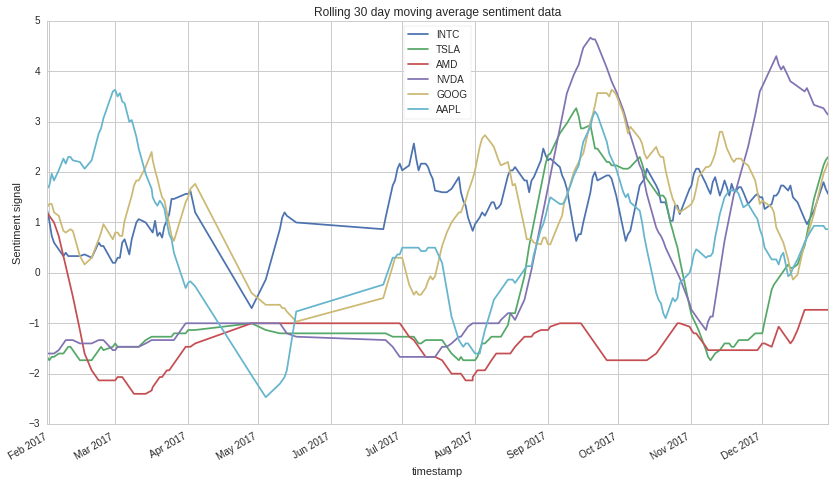

In [162]:
pairs = ['INTC', 'TSLA', 'AMD', 'NVDA', 'GOOG', 'AAPL']
agf_pair = pairs_analysis(pairs, start_date='2017-01-01', end_date='2018-01-01', rolling_period=30)

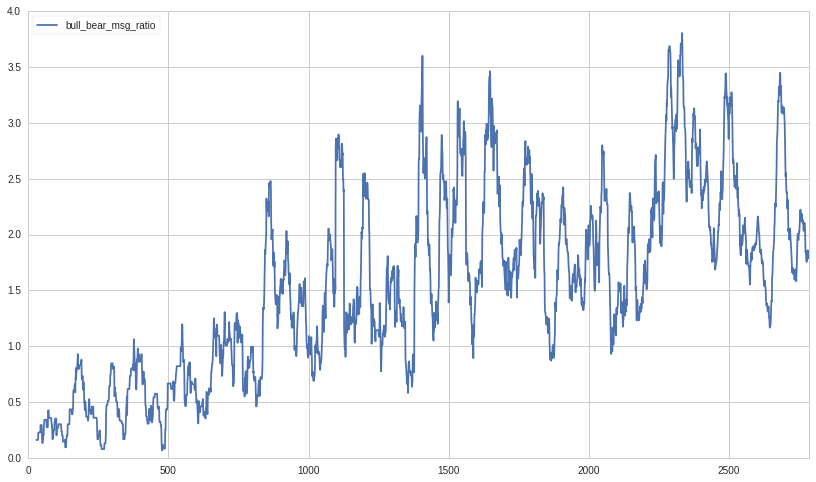

In [171]:
odo(psychsignal.stocktwits.bull_bear_msg_ratio[psychsignal.stocktwits.symbol == 'INTC'], pd.DataFrame).rolling(window=30).mean().plot()

In [105]:
agf_pricing = get_pricing(pairs, start_date='2017-01-01', end_date='2018-01-01', frequency='daily', fields='close_price')

In [160]:
#joined = agf_pair[0]['INTC'].to_frame().join(agf_pricing[symbols('INTC')])
intc_copy = agf_pair[0]['INTC'].to_frame().copy()

intc_copy.index = pd.to_datetime([i.date() for i in intc_copy['INTC'].to_frame().index], utc=True)

joined = intc_copy['INTC'].to_frame().join(agf_pricing[symbols('INTC')].pct_change()).dropna()
#linregress(agf_pair[0]['INTC'].values, agf_pricing[symbols('INTC')].values)

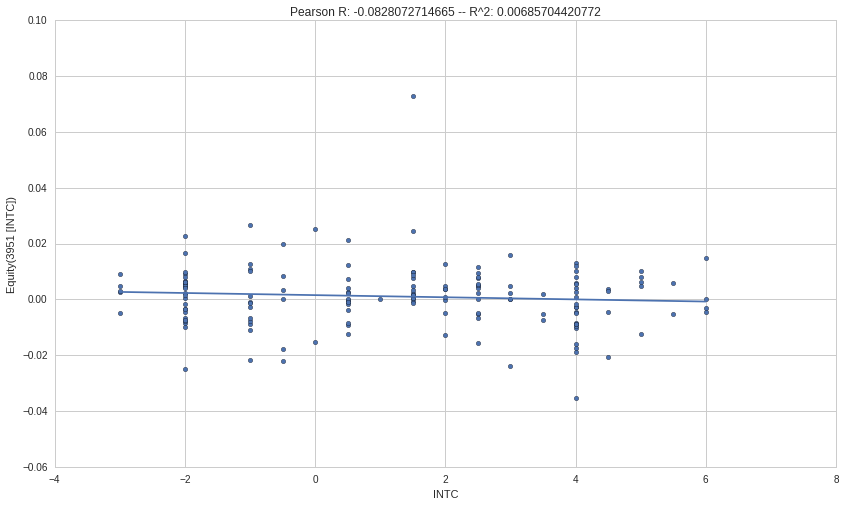

In [161]:
joined.plot(x='INTC', y=symbols('INTC'), kind='scatter')

asdf = linregress(joined['INTC'].values, joined[symbols('INTC')].values)

m = asdf.slope
x = np.linspace(joined['INTC'].min(), joined['INTC'].max(), num=100)
y = (m * x) + asdf.intercept

plt.plot(x, y)
plt.title('Pearson R: %s -- R^2: %s' % (asdf.rvalue, asdf.rvalue * asdf.rvalue))

In [150]:
asdf = linregress(joined['INTC'].values, joined[symbols('INTC')].values)

In [152]:
m = asdf.slope
x = np.linspace(joined['INTC'].min(), joined['INTC'].max(), num=100)
y = (m * x) + asdf.intercept

In [109]:
symbols('INTC')

Equity(3951 [INTC])

In [55]:
'''
function result = johansen(x,p,k)
% PURPOSE: perform Johansen cointegration tests
% -------------------------------------------------------
% USAGE: result = johansen(x,p,k)
% where:      x = input matrix of time-series in levels, (nobs x m)
%             p = order of time polynomial in the null-hypothesis
%                 p = -1, no deterministic part
%                 p =  0, for constant term
%                 p =  1, for constant plus time-trend
%                 p >  1, for higher order polynomial
%             k = number of lagged difference terms used when
%                 computing the estimator
% -------------------------------------------------------
% RETURNS: a results structure:
%          result.eig  = eigenvalues  (m x 1)
%          result.evec = eigenvectors (m x m), where first
%                        r columns are normalized coint vectors
%          result.lr1  = likelihood ratio trace statistic for r=0 to m-1
%                        (m x 1) vector
%          result.lr2  = maximum eigenvalue statistic for r=0 to m-1
%                        (m x 1) vector
%          result.cvt  = critical values for trace statistic
%                        (m x 3) vector [90% 95% 99%]
%          result.cvm  = critical values for max eigen value statistic
%                        (m x 3) vector [90% 95% 99%]
%          result.ind  = index of co-integrating variables ordered by
%                        size of the eigenvalues from large to small
% -------------------------------------------------------
% NOTE: c_sja(), c_sjt() provide critical values generated using
%       a method of MacKinnon (1994, 1996).
%       critical values are available for n<=12 and -1 <= p <= 1,
%       zeros are returned for other cases.
% -------------------------------------------------------
% SEE ALSO: prt_coint, a function that prints results
% -------------------------------------------------------
% References: Johansen (1988), 'Statistical Analysis of Co-integration
% vectors', Journal of Economic Dynamics and Control, 12, pp. 231-254.
% MacKinnon, Haug, Michelis (1996) 'Numerical distribution
% functions of likelihood ratio tests for cointegration',
% Queen's University Institute for Economic Research Discussion paper.
% (see also: MacKinnon's JBES 1994 article
% -------------------------------------------------------

% written by:
% James P. LeSage, Dept of Economics
% University of Toledo
% 2801 W. Bancroft St,
% Toledo, OH 43606
% jlesage@spatial-econometrics.com

% ****************************************************************
% NOTE: Adina Enache provided some bug fixes and corrections that
%       she notes below in comments. 4/10/2000
% ****************************************************************
'''

tdiff = np.diff

class Holder(object):
    pass

def rows(x):
    return x.shape[0]

def trimr(x, front, end):
    if end > 0:
        return x[front:-end]
    else:
        return x[front:]

import statsmodels.tsa.tsatools as tsat
mlag = tsat.lagmat

def mlag_(x, maxlag):
    '''return all lags up to maxlag
    '''
    return x[:-lag]

def lag(x, lag):
    return x[:-lag]

def detrend(y, order):
    if order == -1:
        return y
    return OLS(y, np.vander(np.linspace(-1, 1, len(y)), order + 1)).fit().resid

def resid(y, x):
    r = y - np.dot(x, np.dot(np.linalg.pinv(x), y))
    return r

def coint_johansen(x, p, k, print_on_console=False):

    #    % error checking on inputs
    #    if (nargin ~= 3)
    #     error('Wrong # of inputs to johansen')
    #    end
    nobs, m = x.shape

    # why this?  f is detrend transformed series, p is detrend data
    if (p > -1):
        f = 0
    else:
        f = p

    x = detrend(x, p)
    dx = tdiff(x, 1, axis=0)
    # dx    = trimr(dx,1,0)
    z = mlag(dx, k)  # [k-1:]
#    print z.shape
    z = trimr(z, k, 0)
    z = detrend(z, f)
#    print dx.shape
    dx = trimr(dx, k, 0)

    dx = detrend(dx, f)
    # r0t   = dx - z*(z\dx)
    r0t = resid(dx, z)  # diff on lagged diffs
    # lx = trimr(lag(x,k),k,0)
    lx = lag(x, k)
    lx = trimr(lx, 1, 0)
    dx = detrend(lx, f)
#    print 'rkt', dx.shape, z.shape
    # rkt   = dx - z*(z\dx)
    rkt = resid(dx, z)  # level on lagged diffs
    skk = np.dot(rkt.T, rkt) / rows(rkt)
    sk0 = np.dot(rkt.T, r0t) / rows(rkt)
    s00 = np.dot(r0t.T, r0t) / rows(r0t)
    sig = np.dot(sk0, np.dot(inv(s00), (sk0.T)))
    tmp = inv(skk)
    # du, au = eig(np.dot(tmp, sig))
    au, du = eig(np.dot(tmp, sig))  # au is eval, du is evec
    # orig = np.dot(tmp, sig)

    # % Normalize the eigen vectors such that (du'skk*du) = I
    temp = inv(chol(np.dot(du.T, np.dot(skk, du))))
    dt = np.dot(du, temp)


    # JP: the next part can be done much  easier

    # %      NOTE: At this point, the eigenvectors are aligned by column. To
    # %            physically move the column elements using the MATLAB sort,
    # %            take the transpose to put the eigenvectors across the row

    # dt = transpose(dt)

    # % sort eigenvalues and vectors

    # au, auind = np.sort(diag(au))
    auind = np.argsort(au)
    # a = flipud(au)
    aind = flipud(auind)
    a = au[aind]
    # d = dt[aind,:]
    d = dt[:, aind]

    # %NOTE: The eigenvectors have been sorted by row based on auind and moved to array "d".
    # %      Put the eigenvectors back in column format after the sort by taking the
    # %      transpose of "d". Since the eigenvectors have been physically moved, there is
    # %      no need for aind at all. To preserve existing programming, aind is reset back to
    # %      1, 2, 3, ....

    # d  =  transpose(d)
    # test = np.dot(transpose(d), np.dot(skk, d))

    # %EXPLANATION:  The MATLAB sort function sorts from low to high. The flip realigns
    # %auind to go from the largest to the smallest eigenvalue (now aind). The original procedure
    # %physically moved the rows of dt (to d) based on the alignment in aind and then used
    # %aind as a column index to address the eigenvectors from high to low. This is a double
    # %sort. If you wanted to extract the eigenvector corresponding to the largest eigenvalue by,
    # %using aind as a reference, you would get the correct eigenvector, but with sorted
    # %coefficients and, therefore, any follow-on calculation would seem to be in error.
    # %If alternative programming methods are used to evaluate the eigenvalues, e.g. Frame method
    # %followed by a root extraction on the characteristic equation, then the roots can be
    # %quickly sorted. One by one, the corresponding eigenvectors can be generated. The resultant
    # %array can be operated on using the Cholesky transformation, which enables a unit
    # %diagonalization of skk. But nowhere along the way are the coefficients within the
    # %eigenvector array ever changed. The final value of the "beta" array using either method
    # %should be the same.


    # % Compute the trace and max eigenvalue statistics */
    lr1 = zeros(m)
    lr2 = zeros(m)
    cvm = zeros((m, 3))
    cvt = zeros((m, 3))
    iota = ones(m)
    t, junk = rkt.shape
    for i in range(0, m):
        tmp = trimr(log(iota - a), i , 0)
        lr1[i] = -t * np.sum(tmp, 0)  # columnsum ?
        # tmp = np.log(1-a)
        # lr1[i] = -t * np.sum(tmp[i:])
        lr2[i] = -t * log(1 - a[i])
        cvm[i, :] = c_sja(m - i, p)
        cvt[i, :] = c_sjt(m - i, p)
        aind[i] = i
    # end

    result = Holder()
    # % set up results structure
    # estimation results, residuals
    result.rkt = rkt
    result.r0t = r0t
    result.eig = a
    result.evec = d  # transposed compared to matlab ?
    result.lr1 = lr1
    result.lr2 = lr2
    result.cvt = cvt
    result.cvm = cvm
    result.ind = aind
    result.meth = 'johansen'

    if print_on_console == True:
        print('--------------------------------------------------')
        print('--> Trace Statistics')
        print('variable\t statistic\t Crit-90%\t Crit-95%\t Crit-99%')
        for i in range(len(result.lr1)):
            stat_val = str(round(result.lr1[i], 4))
            crit_1 = str(result.cvt[i, 0])
            crit_2 = str(result.cvt[i, 1])
            crit_3 = str(result.cvt[i, 2])
            
            values = [stat_val, crit_1, crit_2, crit_3]
            
            for index, value in enumerate(values):
                while len(value) < 8:
                    if '.' not in value:
                        value += '.'
                        continue

                    value += '0'
                
                values[index] = value
                
            print('r =', i, '\t\t', values[0], '\t', values[1], '\t', values[2], '\t', values[3])
            
        print('--------------------------------------------------')
        print('--> Eigen Statistics')
        print('variable\t statistic\t Crit-90%\t Crit-95%\t Crit-99%\t')
        
        for i in range(len(result.lr2)):
            stat_val = str(round(result.lr2[i], 4))
            crit_1 = str(result.cvm[i, 0])
            crit_2 = str(result.cvm[i, 1])
            crit_3 = str(result.cvm[i, 2])
            
            values = [stat_val, crit_1, crit_2, crit_3]
            
            for index, value in enumerate(values):
                while len(value) < 8:
                    if '.' not in value:
                        value += '.'
                        continue

                    value += '0'
                
                values[index] = value
            
            print('r =', i, '\t\t', values[0], '\t', values[1], '\t', values[2], '\t', values[3])

        print('--------------------------------------------------')
        print('eigenvectors:\n', result.evec)
        print('--------------------------------------------------')
        print('eigenvalues:\n', result.eig)
        print('--------------------------------------------------')


    return result

def c_sjt(n, p):

# PURPOSE: find critical values for Johansen trace statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sjt(n,p)
# where:    n = dimension of the VAR system
#               NOTE: routine doesn't work for n > 12
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the trace
#          statistic for [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# # References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
#
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com

# these are the values from Johansen's 1995 book
# for comparison to the MacKinnon values
# jcp0 = [ 2.98   4.14   7.02
#        10.35  12.21  16.16
#        21.58  24.08  29.19
#        36.58  39.71  46.00
#        55.54  59.24  66.71
#        78.30  86.36  91.12
#       104.93 109.93 119.58
#       135.16 140.74 151.70
#       169.30 175.47 187.82
#       207.21 214.07 226.95
#       248.77 256.23 270.47
#       293.83 301.95 318.14];




    jcp0 = ((2.9762, 4.1296, 6.9406),
            (10.4741, 12.3212, 16.3640),
            (21.7781, 24.2761, 29.5147),
            (37.0339, 40.1749, 46.5716),
            (56.2839, 60.0627, 67.6367),
            (79.5329, 83.9383, 92.7136),
            (106.7351, 111.7797, 121.7375),
            (137.9954, 143.6691, 154.7977),
            (173.2292, 179.5199, 191.8122),
            (212.4721, 219.4051, 232.8291),
            (255.6732, 263.2603, 277.9962),
            (302.9054, 311.1288, 326.9716))


    jcp1 = ((2.7055, 3.8415, 6.6349),
            (13.4294, 15.4943, 19.9349),
            (27.0669, 29.7961, 35.4628),
            (44.4929, 47.8545, 54.6815),
            (65.8202, 69.8189, 77.8202),
            (91.1090, 95.7542, 104.9637),
            (120.3673, 125.6185, 135.9825),
            (153.6341, 159.5290, 171.0905),
            (190.8714, 197.3772, 210.0366),
            (232.1030, 239.2468, 253.2526),
            (277.3740, 285.1402, 300.2821),
            (326.5354, 334.9795, 351.2150))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (16.1619, 18.3985, 23.1485),
            (32.0645, 35.0116, 41.0815),
            (51.6492, 55.2459, 62.5202),
            (75.1027, 79.3422, 87.7748),
            (102.4674, 107.3429, 116.9829),
            (133.7852, 139.2780, 150.0778),
            (169.0618, 175.1584, 187.1891),
            (208.3582, 215.1268, 228.2226),
            (251.6293, 259.0267, 273.3838),
            (298.8836, 306.8988, 322.4264),
            (350.1125, 358.7190, 375.3203))



    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]



    return jc

def c_sja(n, p):

# PURPOSE: find critical values for Johansen maximum eigenvalue statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sja(n,p)
# where:    n = dimension of the VAR system
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the maximum eigenvalue
#          statistic for: [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com


    jcp0 = ((2.9762, 4.1296, 6.9406),
            (9.4748, 11.2246, 15.0923),
            (15.7175, 17.7961, 22.2519),
            (21.8370, 24.1592, 29.0609),
            (27.9160, 30.4428, 35.7359),
            (33.9271, 36.6301, 42.2333),
            (39.9085, 42.7679, 48.6606),
            (45.8930, 48.8795, 55.0335),
            (51.8528, 54.9629, 61.3449),
            (57.7954, 61.0404, 67.6415),
            (63.7248, 67.0756, 73.8856),
            (69.6513, 73.0946, 80.0937))

    jcp1 = ((2.7055, 3.8415, 6.6349),
            (12.2971, 14.2639, 18.5200),
            (18.8928, 21.1314, 25.8650),
            (25.1236, 27.5858, 32.7172),
            (31.2379, 33.8777, 39.3693),
            (37.2786, 40.0763, 45.8662),
            (43.2947, 46.2299, 52.3069),
            (49.2855, 52.3622, 58.6634),
            (55.2412, 58.4332, 64.9960),
            (61.2041, 64.5040, 71.2525),
            (67.1307, 70.5392, 77.4877),
            (73.0563, 76.5734, 83.7105))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (15.0006, 17.1481, 21.7465),
            (21.8731, 24.2522, 29.2631),
            (28.2398, 30.8151, 36.1930),
            (34.4202, 37.1646, 42.8612),
            (40.5244, 43.4183, 49.4095),
            (46.5583, 49.5875, 55.8171),
            (52.5858, 55.7302, 62.1741),
            (58.5316, 61.8051, 68.5030),
            (64.5292, 67.9040, 74.7434),
            (70.4630, 73.9355, 81.0678),
            (76.4081, 79.9878, 87.2395))


    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]


    return jc

def get_half_life(df, spread_col='spread', lag=1, sigfigs=5): 
    # To get the half life of the mean reversion series, we apparently have to create a 
    # lagged version of our time series, and run an OLS test on it. We then get the Beta
    # and use it in the Ornstein-Uhlenbeck equations to determine the half-life.

    # This returns an unusable first entry. Filter it out
    spread_lag = df[spread_col].shift(1).iloc[1:]

    # Make data the same shape, and calculate the return from the original vs. lagged period
    spread_return = df[spread_col].iloc[1:] - spread_lag

    # Adds a bunch of 1's into the DataFrame. I don't know why this is needed *-*
    sl2 = sm.add_constant(spread_lag)

    # Run Ordinary Least Squares (OLS) and fit the data
    result = sm.OLS(spread_return, sl2).fit()

    # Extract the value we're after
    beta = result.params[1]
    
    # return half-life of our mean reverting process
    return round(-np.log(2) / beta, sigfigs)